In [9]:
from skmultiflow.trees import HoeffdingTree, HoeffdingTreeClassifier
import random
import matplotlib
import matplotlib.pyplot as plt
from numpy import array
import numpy as np
import pandas as pd

In [10]:
df=pd.read_csv(filename)
df["light"]=df["light"].astype(int)
df["motion"]=df["motion"].astype(int)
df[df.light == 1].count()
--112527
df[df.light == 0].count()
--292657
df.count()
--405184

405184

In [3]:
# parameters
filename="iot_telemetry_data.csv"
N=100               # the size of reservoir (more than the grace perod)
maturity_level=10   # we wait until the tree reaches certain number of leaves 
                    # to start prequential evaluation

# hyperparameters tuning
grace_period=10           # default 200
split_criterion ='gini'   # default 'info-gain'
split_confidence = 0.001  # default 1e-07
leaf_prediction = 'mc'    # mc = majority class vote, default 'nba'
binary_split = False

In [11]:
def data_preparation(filename):
    '''Prepare the data for incremental training'''
    df=pd.read_csv(filename)
    df["light"]=df["light"].astype(int)
    df["motion"]=df["motion"].astype(int)
    select_cols = ['co', 'humidity', 'lpg', 'motion','smoke', 'temp', 'light']
    data = df[select_cols].to_numpy()
    
    return data

In [12]:
def initialize_model(grace_period, split_criterion, split_confidence, leaf_prediction, binary_split):
    '''Initialize the model'''
    ht = HoeffdingTreeClassifier(
        grace_period=grace_period, 
        split_criterion=split_criterion, 
        split_confidence = split_confidence,
        leaf_prediction = leaf_prediction,
        binary_split = binary_split)
    return ht

In [13]:
def get_data_point(data, index):
    '''Return data point by index'''
    X=data[index][:-1]
    # X should be numpy array with shape (n_samples, n_features)
    X=np.array([X])
    
    #print(X)
    return X

In [14]:
def get_class_value(data, index):
    '''Return the class by index'''
    class_value = data[index][-1]
    
    #print(class_value)
    return np.array([class_value])

In [15]:
def get_f1_score(countTP, countFP, countFN):
    f1_score=0
    
    if (((countTP + countFP)==0) or ((countTP + countFN)==0)):
        f1_score=0
    else:
        f1_score = countTP/(countTP + 0.5*(countFP+countFN))
    
    return f1_score
         

In [16]:
def print_confusion_matrix(countInstances, countCorrectPredictions, countTP, countFP, countFN, countTN, current_f1_score):
    '''print the confusion matrix every 1000 data points'''
    if (countInstances>0) and (countInstances % 1000 ==0):
        print(f"{'Total'.ljust(6)} | {'Correct'.ljust(6)}| {'TP'.ljust(6)} | {'FP'.ljust(6)} | {'FN'.ljust(6)} | {'TN'.ljust(6)} | {'F-score'.ljust(6)}")
        print(f"{str(countInstances).ljust(6)} | {str(countCorrectPredictions).ljust(6)} | {str(countTP).ljust(6)} | {str(countFP).ljust(6)} | {str(countFN).ljust(6)} | {str(countTN).ljust(6)} | {str(round(current_f1_score,4)).ljust(6)}")
        

In [22]:
def train_with_reservoir_sampling(filename, ht, N):
    ''' Train Hoeffding Tree Model with Reservoir sampling
        Print the confusion matric every 1000 samples
        Params: 
            data - the data stream
            ht - the initialized Hoeffding Tree model
            N - the size of reservoir   
    '''
    #initialization of variables
    reservoir =[]          # reservoir for majority class
    minority_array = []    # array of the same size as the reservoir for minority class

    countInstances =0
    countCorrectPredictions=0
    countTP=0              # true positives
    countFP=0              # false positives
    countFN=0              # false negatives
    countTN=0              # true negatives

    result_accuracy=[]
    result_f1_score=[]
    majorityClass =0
    minorityClass =1
    countMinority =0       # 0 to N - to make sure we use equal number of both classes in trainning
    
    nbrMajorityTotal=0     # display total training instances from the majority class
    nbrMinorityTotal=0     # display total training instances from minority class
    
    data = data_preparation(filename)
    
   
    # stream the data
    for i in range(len(data)):

        # read the next example from the stream
        y = get_class_value(data, i) 
        X = get_data_point(data, i)

        # apply test then train method
        if (ht.get_model_measurements['Tree size (leaves)']>= maturity_level):
            countInstances +=1

            y_predict = ht.predict(X)

            # calculate prequential metrics
            if (y_predict[0] == y):
                countCorrectPredictions+=1
            if (y_predict[0]==1 and y==1):
                countTP+=1
            if (y_predict[0]==1 and y==0):
                countFP+=1
            if (y_predict[0]==0 and y==1):
                countFN+=1
            if (y_predict[0]==0 and y==0):
                countTN+=1

            current_accuracy = countCorrectPredictions/ countInstances        
            current_f1_score = get_f1_score(countTP, countFP, countFN)

            # print current confusion matrix
            print_confusion_matrix(countInstances, countCorrectPredictions, countTP, countFP, countFN, countTN, current_f1_score)

        else:
            current_f1_score=0
            current_accuracy=0

        # record current metric
        result_accuracy.append(current_accuracy)
        result_f1_score.append(current_f1_score)

        # now train the model
        if (y == majorityClass):
            if (len(reservoir) < N):
                # accumulate N elements in the reservoir
                reservoir.append(data[i])
            else:
                # uniformly sample data 
                m=random.randint(0, i)
                if (m<N):
                    reservoir[m]=data[i]          
        else:
            # need N data points in the reservoir before training
            if (len(reservoir) == N) : 
                countMinority+=1

                # train tree with the current sample (minority)   
                ht=ht.partial_fit(X = X,y = y)
                nbrMinorityTotal+=1

            # train with N points from the majority class as well
            if (countMinority ==N):

                for r in reservoir:    
                    ht=ht.partial_fit(X = np.array([r[:-1]]),y=np.array([r[-1]]))
                    nbrMajorityTotal+=1

                # empty the reservoir and start over
                reservoir=[]
                countMinority =0 

    print(f"Trained with majority class - {nbrMajorityTotal}")
    print(f"Trained with minority class - {nbrMajorityTotal}")
    
    return (result_f1_score, result_accuracy)


In [23]:
ht = initialize_model(grace_period,split_criterion, split_confidence,leaf_prediction,binary_split)

(result_f1_score, result_accuracy) = train_with_reservoir_sampling(filename, ht, N)

print("Final model:*****************************")
print(ht.get_model_measurements)

Total  | Correct| TP     | FP     | FN     | TN     | F-score
1000   | 1000   | 516    | 0      | 0      | 484    | 1.0   
Total  | Correct| TP     | FP     | FN     | TN     | F-score
2000   | 1788   | 837    | 212    | 0      | 951    | 0.8876
Total  | Correct| TP     | FP     | FN     | TN     | F-score
3000   | 2669   | 1102   | 331    | 0      | 1567   | 0.8694
Total  | Correct| TP     | FP     | FN     | TN     | F-score
4000   | 3596   | 1359   | 404    | 0      | 2237   | 0.8706
Total  | Correct| TP     | FP     | FN     | TN     | F-score
5000   | 4474   | 1628   | 526    | 0      | 2846   | 0.8609
Total  | Correct| TP     | FP     | FN     | TN     | F-score
6000   | 5291   | 1913   | 709    | 0      | 3378   | 0.8437
Total  | Correct| TP     | FP     | FN     | TN     | F-score
7000   | 6282   | 2186   | 718    | 0      | 4096   | 0.8589
Total  | Correct| TP     | FP     | FN     | TN     | F-score
8000   | 7282   | 2468   | 718    | 0      | 4814   | 0.873 
Total  | Correct

Total  | Correct| TP     | FP     | FN     | TN     | F-score
68000  | 64916  | 18299  | 1579   | 1505   | 46617  | 0.9223
Total  | Correct| TP     | FP     | FN     | TN     | F-score
69000  | 65775  | 18573  | 1720   | 1505   | 47202  | 0.9201
Total  | Correct| TP     | FP     | FN     | TN     | F-score
70000  | 66654  | 18847  | 1841   | 1505   | 47807  | 0.9185
Total  | Correct| TP     | FP     | FN     | TN     | F-score
71000  | 67654  | 19132  | 1841   | 1505   | 48522  | 0.9196
Total  | Correct| TP     | FP     | FN     | TN     | F-score
72000  | 68653  | 19412  | 1842   | 1505   | 49241  | 0.9206
Total  | Correct| TP     | FP     | FN     | TN     | F-score
73000  | 69653  | 19680  | 1842   | 1505   | 49973  | 0.9216
Total  | Correct| TP     | FP     | FN     | TN     | F-score
74000  | 70650  | 19939  | 1843   | 1507   | 50711  | 0.9225
Total  | Correct| TP     | FP     | FN     | TN     | F-score
75000  | 71630  | 20191  | 1844   | 1526   | 51439  | 0.923 
Total  | Correct

Total  | Correct| TP     | FP     | FN     | TN     | F-score
135000 | 129040 | 36396  | 3267   | 2693   | 92644  | 0.9243
Total  | Correct| TP     | FP     | FN     | TN     | F-score
136000 | 130039 | 36671  | 3267   | 2694   | 93368  | 0.9248
Total  | Correct| TP     | FP     | FN     | TN     | F-score
137000 | 131039 | 36929  | 3267   | 2694   | 94110  | 0.9253
Total  | Correct| TP     | FP     | FN     | TN     | F-score
138000 | 132039 | 37197  | 3267   | 2694   | 94842  | 0.9258
Total  | Correct| TP     | FP     | FN     | TN     | F-score
139000 | 133034 | 37461  | 3272   | 2694   | 95573  | 0.9262
Total  | Correct| TP     | FP     | FN     | TN     | F-score
140000 | 134030 | 37726  | 3276   | 2694   | 96304  | 0.9267
Total  | Correct| TP     | FP     | FN     | TN     | F-score
141000 | 134928 | 37995  | 3378   | 2694   | 96933  | 0.926 
Total  | Correct| TP     | FP     | FN     | TN     | F-score
142000 | 135818 | 38259  | 3487   | 2695   | 97559  | 0.9252
Total  | Correct

Total  | Correct| TP     | FP     | FN     | TN     | F-score
202000 | 193869 | 53824  | 4670   | 3461   | 140045 | 0.9298
Total  | Correct| TP     | FP     | FN     | TN     | F-score
203000 | 194848 | 54103  | 4672   | 3480   | 140745 | 0.9299
Total  | Correct| TP     | FP     | FN     | TN     | F-score
204000 | 195720 | 54568  | 4727   | 3553   | 141152 | 0.9295
Total  | Correct| TP     | FP     | FN     | TN     | F-score
205000 | 196702 | 55105  | 4745   | 3553   | 141597 | 0.93  
Total  | Correct| TP     | FP     | FN     | TN     | F-score
206000 | 197702 | 55645  | 4745   | 3553   | 142057 | 0.9306
Total  | Correct| TP     | FP     | FN     | TN     | F-score
207000 | 198702 | 56180  | 4745   | 3553   | 142522 | 0.9312
Total  | Correct| TP     | FP     | FN     | TN     | F-score
208000 | 199649 | 56661  | 4745   | 3606   | 142988 | 0.9314
Total  | Correct| TP     | FP     | FN     | TN     | F-score
209000 | 200406 | 56945  | 4745   | 3849   | 143461 | 0.9298
Total  | Correct

Total  | Correct| TP     | FP     | FN     | TN     | F-score
269000 | 258707 | 71778  | 5817   | 4476   | 186929 | 0.9331
Total  | Correct| TP     | FP     | FN     | TN     | F-score
270000 | 259670 | 72034  | 5842   | 4488   | 187636 | 0.9331
Total  | Correct| TP     | FP     | FN     | TN     | F-score
271000 | 260638 | 72291  | 5874   | 4488   | 188347 | 0.9331
Total  | Correct| TP     | FP     | FN     | TN     | F-score
272000 | 261632 | 72538  | 5880   | 4488   | 189094 | 0.9333
Total  | Correct| TP     | FP     | FN     | TN     | F-score
273000 | 262631 | 72788  | 5881   | 4488   | 189843 | 0.9335
Total  | Correct| TP     | FP     | FN     | TN     | F-score
274000 | 263631 | 73055  | 5881   | 4488   | 190576 | 0.9337
Total  | Correct| TP     | FP     | FN     | TN     | F-score
275000 | 264631 | 73305  | 5881   | 4488   | 191326 | 0.9339
Total  | Correct| TP     | FP     | FN     | TN     | F-score
276000 | 265631 | 73567  | 5881   | 4488   | 192064 | 0.9342
Total  | Correct

Total  | Correct| TP     | FP     | FN     | TN     | F-score
336000 | 325171 | 88581  | 5901   | 4928   | 236590 | 0.9424
Total  | Correct| TP     | FP     | FN     | TN     | F-score
337000 | 326171 | 88841  | 5901   | 4928   | 237330 | 0.9426
Total  | Correct| TP     | FP     | FN     | TN     | F-score
338000 | 327171 | 89097  | 5901   | 4928   | 238074 | 0.9427
Total  | Correct| TP     | FP     | FN     | TN     | F-score
339000 | 328171 | 89357  | 5901   | 4928   | 238814 | 0.9429
Total  | Correct| TP     | FP     | FN     | TN     | F-score
340000 | 329171 | 89613  | 5901   | 4928   | 239558 | 0.943 
Total  | Correct| TP     | FP     | FN     | TN     | F-score
341000 | 330170 | 89868  | 5902   | 4928   | 240302 | 0.9432
Total  | Correct| TP     | FP     | FN     | TN     | F-score
342000 | 331170 | 90116  | 5902   | 4928   | 241054 | 0.9433
Total  | Correct| TP     | FP     | FN     | TN     | F-score
343000 | 332170 | 90385  | 5902   | 4928   | 241785 | 0.9435
Total  | Correct

Text(0.5, 1.0, 'Accuracy and F1-Score of Hoeffding Tree')

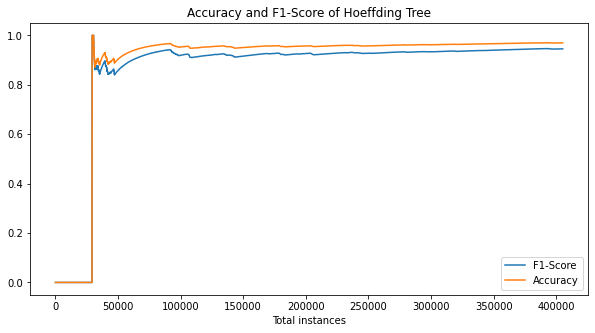

In [24]:
plt.figure(figsize=(10,5))
plt.plot(result_f1_score, label="F1-Score")
plt.plot(result_accuracy, label="Accuracy")
plt.legend()
plt.xlabel("Total instances")
plt.title("Accuracy and F1-Score of Hoeffding Tree")

Text(0.5, 1.0, 'Accuracy and F1-Score of Hoeffding Tree')

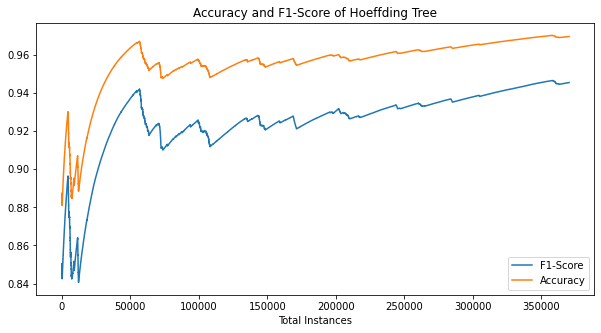

In [25]:
# take only the the first few results
plt.figure(figsize=(10,5))
plt.plot(result_f1_score[35000:], label="F1-Score")
plt.plot(result_accuracy[35000:], label="Accuracy")
plt.legend()
plt.xlabel("Total Instances")
plt.title("Accuracy and F1-Score of Hoeffding Tree")